In [70]:
#import necessary packages
import tskit
import math
import sys
import io
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy.integrate as integrate

In [ ]:
burnin = np.array([10000.0, 1243.0, 1052.0, 1003.0, 848.0])
N = 1000.0
totalGen = 10000.0
Ud = np.array(["0.1", "0.5", "1", "2", "10"])
Udnum = Ud.astype(float)
BoykoSd = 0.029
linkagesblocks = 200.0
chromosomenumber = 23.0 
totallinkageblocks = linkagesblocks*chromosomenumber
foldernames = "data/datafor_relative_tskitstatus_ON_BURNIN_fixationcalc_OFF_Sb_1.0000_deldist_exponential_bendist_exponential_mub_0.0000_chromnum_23_N0_1000_mud_" + Ud + "_L_200_seed_24_Sd_0.029000/"

In [ ]:
for i in range(len(Ud)):
    #read tables for tskit
    with open(foldernames[i] + 'sitetable.txt') as f:
        sites = f.read()

    with open(foldernames[i] + 'nodetable.txt') as f:
        nodes = f.read()

    with open(foldernames[i] + 'mutationtable.txt') as f:
        mutations = f.read()

    with open(foldernames[i] + 'edgetable.txt') as f:
        edges = f.read()

    #load in the tree sequence data
    ts = tskit.load_text(
        nodes = io.StringIO(nodes),
        edges = io.StringIO(edges),
        sites = io.StringIO(sites),
        mutations = io.StringIO(mutations),
        strict = False)
    #ts_2 = TableCollection.tree_sequence("tables.trees")

    G = float(N*10)

    threshold_gen = (G-burnin[i])*N
    #output the fixation time table for fixed mutations in final sample
    with open(foldernames[i] + 'fixed_mut.txt', 'w', encoding='utf-8') as f:
        print('mutation', sep='\t', file=f)
        for tree in ts.trees(root_threshold=2):
            for root in tree.roots:
                # Create a list to store mutations that meet the time threshold
                filtered_mutations = []
                for mutation in tree.mutations():
                    # Get the associated node ID for the mutation
                    node_id = mutation.node

                    # Access the time attribute of the node
                    node_time = tree.time(node_id)
                    
                    if node_time <= threshold_gen:
                        filtered_mutations.append(mutation)
                
                # Iterate through the filtered mutations to find those where root == mutation.node
                for mutation in filtered_mutations:
                    if root == mutation.node:
                        print(mutation.derived_state, sep='\t', file=f)

the size of the sample of text-based ts is 2000.
the size of the sample of text-based ts is 2000.
the size of the sample of text-based ts is 2000.
the size of the sample of text-based ts is 2000.
the size of the sample of text-based ts is 2000.


In [ ]:
#function returns Ne as in Matheson and Masel 2024. 
#r=2 per chromosome, two recombination events for chromosome arm
def calculate_Ne(Ud, sh, totallinkageblocks, chromosomenumber, N):
  Ne = N*np.exp(-8.0*Ud*(1.0-(1.0/totallinkageblocks))*sh)*np.exp(-Ud/(chromosomenumber*2.0))
  return Ne

#working on this, check that the signs of the math work first
def PfixDFE(x, Ud, meansd, totallinkageblocks, chromosomenumber, N):
  Ne = calculate_Ne(Ud, meansd, totallinkageblocks, chromosomenumber, N)
  #negative because I consider deleterious effect sizes positive
  Mcandlish_sd = np.log(1.0-x)
  Pfix = (1.0-np.exp(-2.0*(Mcandlish_sd), dtype=np.float128))/(1.0-np.exp(-4*Ne*(Mcandlish_sd), dtype=np.float128))
  DFE = np.exp(-x/(meansd), dtype=np.float128)/meansd
  return Pfix*DFE

def calculate_PfixDFE_total(Ud, meansd, totallinkageblocks, chromosomenumber, N):
  result = integrate.quad(PfixDFE, 0.0, 1.0, args=(Ud, meansd, totallinkageblocks, chromosomenumber, N))
  return abs(result[0])

def calculate_PfixDFE_toMaxsd(Ud, meansd, totallinkageblocks, chromosomenumber, N, Maxsd):
  result = integrate.quad(PfixDFE, Maxsd, 1.0, args=(Ud, meansd, totallinkageblocks, chromosomenumber, N))
  return abs(result[0])

def calculate_CDF_PfixDFE(Ud, meansd, totallinkageblocks, chromosomenumber, N, Maxsd):
  totalint = calculate_PfixDFE_total(Ud, meansd, totallinkageblocks, chromosomenumber, N)
  intuntilMaxsd = calculate_PfixDFE_toMaxsd(Ud, meansd, totallinkageblocks, chromosomenumber, N, Maxsd)
  return intuntilMaxsd/totalint

vCDF = np.vectorize(calculate_CDF_PfixDFE)

/tmp/ipykernel_38602/1422350558.py:12: RuntimeWarning: overflow encountered in exp
  Pfix = (1.0-np.exp(-2.0*(Mcandlish_sd), dtype=np.float128))/(1.0-np.exp(-4*Ne*(Mcandlish_sd), dtype=np.float128))


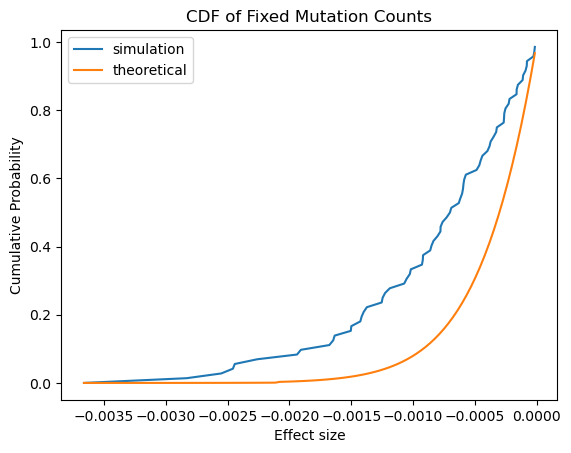

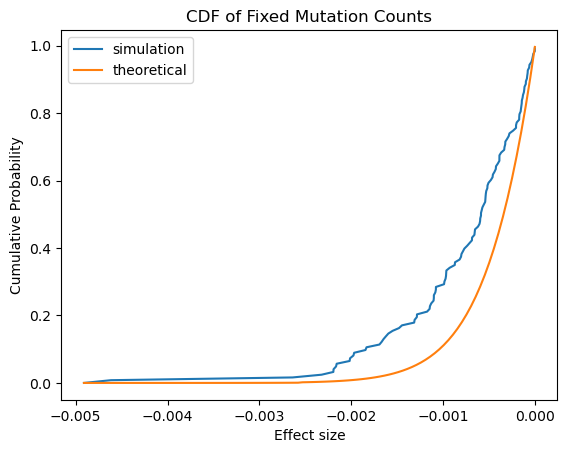

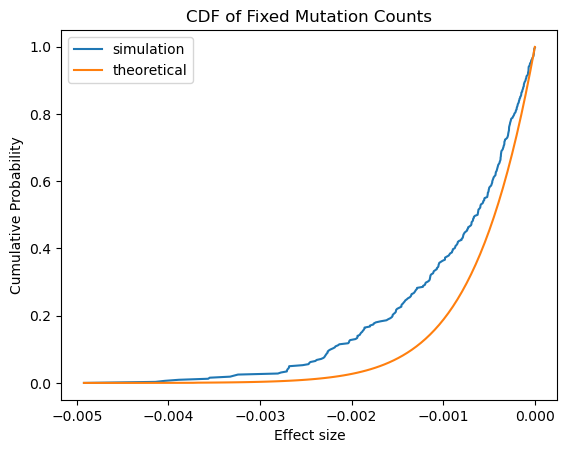

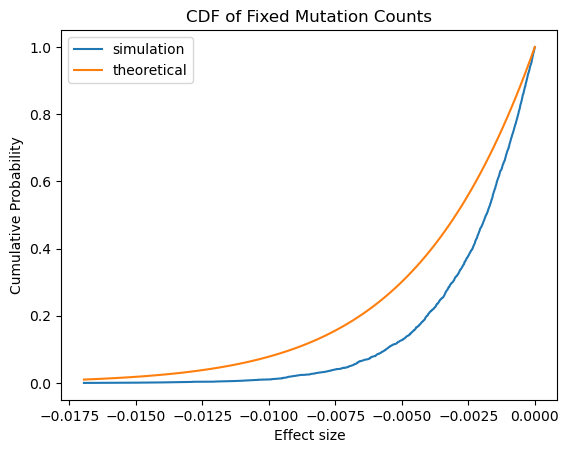

In [116]:
#create cdfs for the fixed mutations
for i in range(1, len(Ud)):
    allFixedData = np.loadtxt(foldernames[i] + "fixed_mut.txt", skiprows=1)
    # Attempt at creating a CDF (without binning)
    numVals = len(allFixedData)
    sorted = np.sort(allFixedData)
    CDF = np.arange(numVals) / float(numVals)
    #calculate theoretical expectations
    sds = np.linspace(min(-sorted), max(-sorted), 100)
    theoreticaCDF = vCDF(Udnum[i], BoykoSd, totallinkageblocks, chromosomenumber, N, sds)
    plt.figure() 
    plt.xlabel("Effect size")
    plt.ylabel("Cumulative Probability")
    plt.title("CDF of Fixed Mutation Counts")
    plt.plot(sorted, CDF, label = 'simulation')
    plt.plot(-sds, theoreticaCDF, label = 'theoretical')
    plt.legend()
    plt.savefig("graphs/CDF_Boykosd_Ud_" + Ud[i] + ".png")